デバイアス後の分散表現を使った方が分類精度が平均的に悪くなることを検定したい。  
データ
- exp1: デバイアス前の分散表現による分類精度
- exp2: デバイアス後の分散表現による分類精度

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
%matplotlib inline

In [2]:
# 正規性の検定(Q-Qプロット, シャピロ-ウィルク検定)
def normality(data):
    stats.probplot(data, dist="norm", plot=plt)
    plt.show()
    W, p = stats.shapiro(data)
    print("{:.16f}".format(p))

In [3]:
# 分布の表示
def distribution(exp1, exp2, num_divide):
    max_data = max(max(exp1), max(exp2))
    min_data = min(min(exp1), min(exp2))
    width = (max_data - min_data) / num_divide
    hist1 = []
    hist2 = []
    for i in range(num_divide):
        hist1.append(((min_data+width*i < exp1) & (exp1 < min_data+width*(i+1))).sum())
        hist2.append(((min_data+width*i < exp2) & (exp2 < min_data+width*(i+1))).sum())
        if i+1 == num_divide:
            if max(exp1) == max_data:
                hist1[-1] += 1
            elif max(exp2) == max_data:
                hist2[-1] += 1
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    ax.hist(exp1, [min_data+width*(i+0.5) for i in range(num_divide)], alpha = 0.5, label='undebiased')
    ax.hist(exp2, [min_data+width*(i+0.5) for i in range(num_divide)], alpha = 0.5, label='debiased')
    ax.legend(fontsize=24, loc='upper right')
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    fig.show()

In [4]:
# 区間推定
def interval(data, alpha):
    t_dist = stats.t(loc=data.mean(),
                     scale=np.sqrt(data.var()/10),
                     df=len(data)-1)
    bottom, up = t_dist.interval(alpha=alpha)
    mean = data.mean()
    print('{:.16f} < mean < {:.16f}, {}'.format(bottom, up, mean))

# 二群の母平均の差についての検定(AG_NEWS)
参考文献
- 正規性、分散の検定：https://qiita.com/ground0state/items/80b426e4d39193a609bc
- 二群の平均の検定：https://qiita.com/suaaa7/items/745ac1ca0a8d6753cf60

母平均の検定方法は多数あるが、それぞれ前提条件が異なる。  
e.g.)Studentのt検定は正規分布に従う母分散の等しい対応のない二群の母平均の検定方法  
従って母平均についていきなり検定を行うのではなく、前提条件を確かめる必要がある。  
![早見表](https://camo.qiitausercontent.com/0246c74ef4b20b431c6a69c47b25fd3f46e94ea5/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f3231313731322f65626563323364312d633336652d653562612d336332662d3962623961363533373066372e706e67)  
このとき分布の正規性や母分散が等しいかなどは事前にわかっていない場合もあるので、その場合はそれらに対しても検定を行う必要がある。(ただ検定の前に検定をするのはあまり良くないという派閥の人もいるらしい)  
## 標本の対応について
対応とは二群の標本間の対応についてである。  
e.g.)  
あるクラスの1年時の身長と2年時の身長の比較→対応がある  
異なる2つのクラスの身長の比較→対応がない
## 正規性について
標本が正規分布に従うか否かは以下の方法によって確認する。
- ヒストグラムによる可視化
    - 簡単だが区間の取り方によって結果が変わったり見る人の感覚頼みなので信頼性は低い
- Q-Qプロットによる可視化
    - まあやっておいて損はない
- シャピロ・ウィルク検定
    - まあやっておいて損はない
    - 帰無仮説は「母集団が正規分布である」なのであくまでも正規性は結論付けられないことに注意
- コルモゴロフ・スミノフ検定
    - データがたくさんないとできない(数千くらい必要らしい)
    - 帰無仮説は「母集団が正規分布である」なのであくまでも正規性は結論付けられないことに注意

In [47]:
df = pd.read_csv('../outputs/AGNEWS_20210610_acc.csv')
exp1 = df['undebiased']
exp2 = df['debiased']

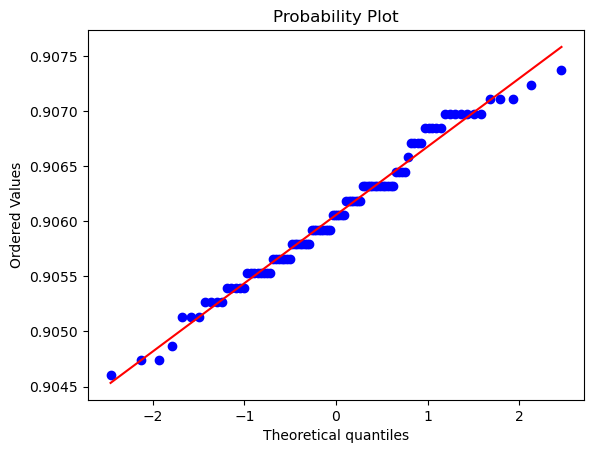

0.1824961155653000


In [6]:
normality(exp1)

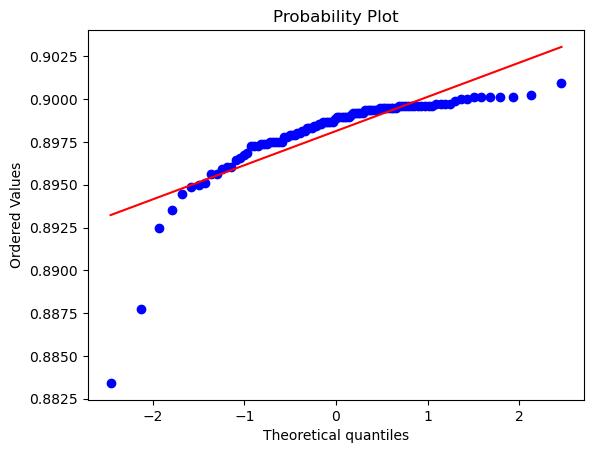

0.0000000000002157


In [7]:
normality(exp2)

## 分散について
二群の母分散が等しいか否かはF検定によって確認する。  
var_exp1 != var_exp2に興味があるので両側検定

In [8]:
var_exp1 = np.var(exp1)
var_exp2 = np.var(exp2)

F = var_exp1 / var_exp2
dfn = len(exp1)-1
dfd = len(exp2)-1

p_left = stats.f.cdf(F, dfn, dfd)
p_right = stats.f.sf(F, dfn, dfd)
p = min(p_left, p_right) * 2
print("{:.16f}".format(p))

0.0000000000000000


## 平均の検定

- 対応：random seedを固定したのであり
- 正規性：わからない、検定結果からも両方には仮定できない
- 等分散：わからない、検定結果から仮定はできる

検定の前に検定ダメ派の意見を考えれば今回はウィルコクソンの符号順位和検定が妥当。  
またexp1に関しては正規性を仮定できそうだが、exp2は正規性を仮定できないのでどちらにせよ今回はウィルコクソンの符号順位和検定が妥当。  
mean_exp1 > mean_exp2に興味があるので片側検定。

In [9]:
# ウィルコクソンの符号順位和検定
W,p = stats.wilcoxon(exp1, exp2, alternative='greater')
print("{:.16f}".format(p))

0.0000000000000000


従って有意水準1%以下でmean_exp1 > mean_exp2といえる

## 分布の表示

<ipython-input-30-d76a96ed49ec>:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


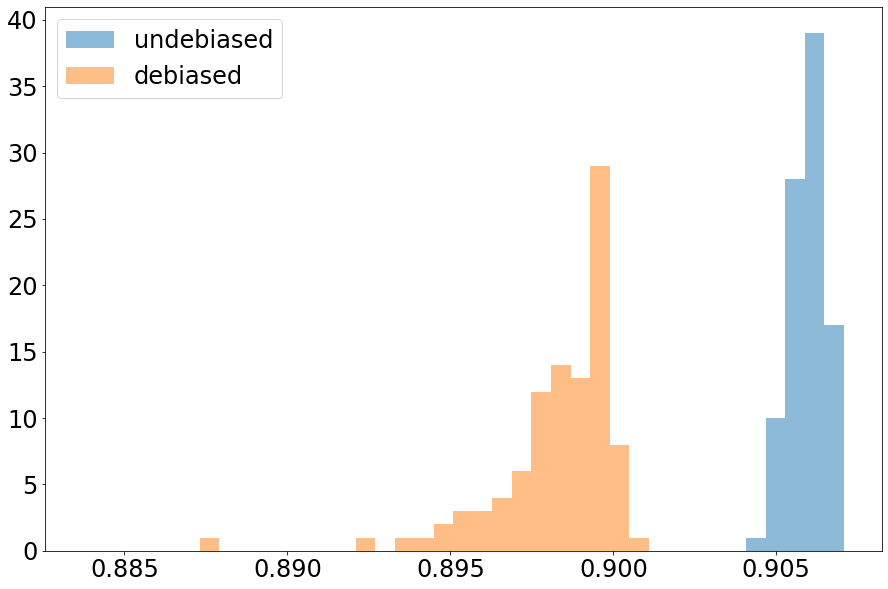

In [31]:
distribution(exp1, exp2, 40)

## 区間推定

In [48]:
interval(exp1, 0.99)
interval(exp2, 0.99)

0.9055464423169682 < mean < 0.9065666293631008, 0.9060565358400345
0.8961444787324647 < mean < 0.9001370199381132, 0.898140749335289


# DBpedia

In [49]:
df = pd.read_csv('../outputs/DBpedia_20210614_acc.csv')
exp1 = df['undebiased']
exp2 = df['debiased']

## 対応について
random seedを固定したので対応はある

## 正規性について
わからない

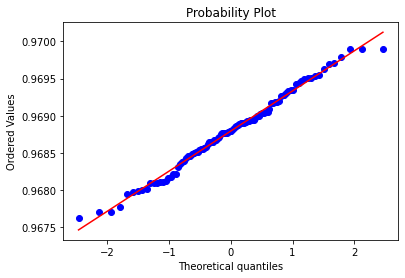

0.4560202062129974


In [34]:
normality(exp1)

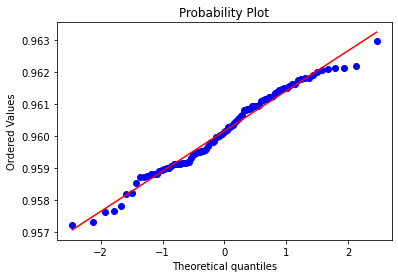

0.1465562731027603


In [35]:
normality(exp2)

有意水準5%で正規性がないとは結論付けられない  
→Q-Qプロットの結果と合わせれば正規性があると仮定できそう

## 平均の検定
検定の前に検定ダメ派でいくならウイルコクソンの符号順位和検定  
正規性が仮定できるとして話を進めるなら対応のあるt検定

In [36]:
# ウィルコクソンの符号順位和検定
W,p = stats.wilcoxon(exp1, exp2, alternative='greater')
print("{:.16f}".format(p))

0.0000000000000000


In [37]:
# 対応のあるt検定
W,p = stats.ttest_rel(exp1, exp2, alternative='greater')
print("{:.16f}".format(p))

0.0000000000000000


従ってどちらにせよ有意水準1%以下でmean_exp1 > mean_exp2といえる

## 分布の表示

<ipython-input-30-d76a96ed49ec>:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


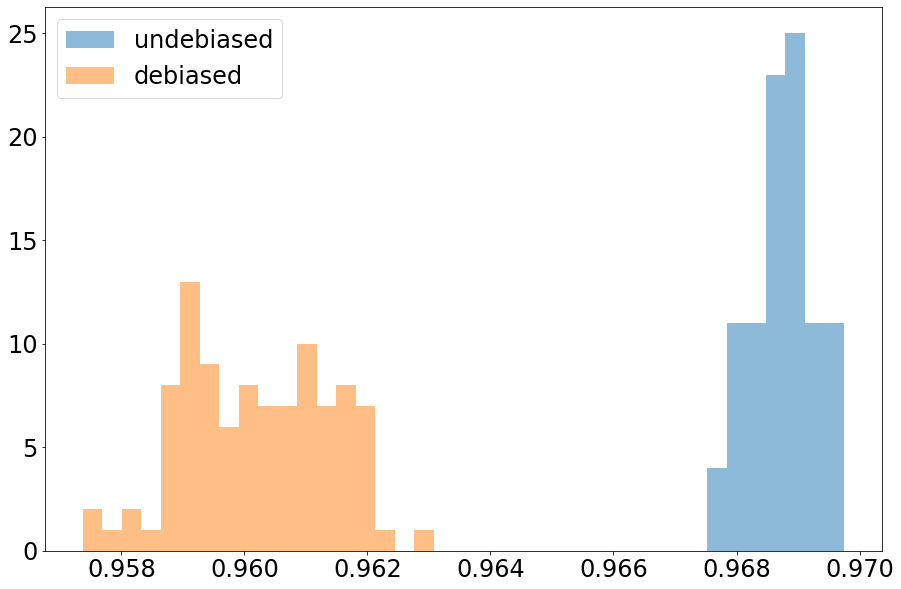

In [38]:
distribution(exp1, exp2, 40)

## 区間推定

In [50]:
interval(exp1, 0.99)
interval(exp2, 0.99)

0.9683502071878621 < mean < 0.9692375141599466, 0.9687938606739044
0.9591199660903493 < mean < 0.9611891805523356, 0.9601545733213425


# SQuAD1.1
- 対応：あり
- 正規性：わからない

In [5]:
exp1 = pd.read_csv('../outputs/QA_results_undebiased.csv')['acc']
exp2 = pd.read_csv('../outputs/QA_results_debiased.csv')['acc']

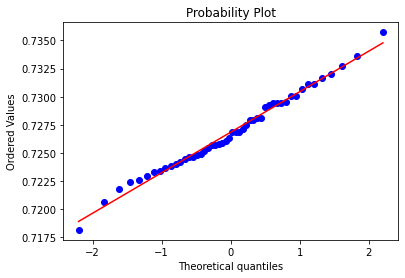

0.9831736683845520


In [6]:
normality(exp1)

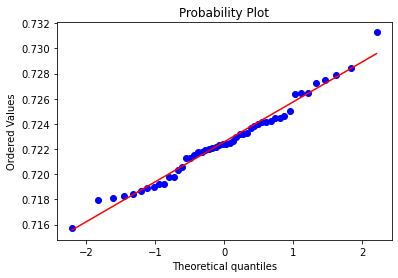

0.6506769657135010


In [7]:
normality(exp2)

In [8]:
# ウィルコクソンの符号順位和検定
W,p = stats.wilcoxon(exp1, exp2, alternative='greater')
print("{:.16f}".format(p))

0.0000000005766505


In [9]:
# 対応のあるt検定
W,p = stats.ttest_rel(exp1, exp2, alternative='greater')
print("{:.16f}".format(p))

0.0000000000002264


<ipython-input-3-6ccb0eeab99d>:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


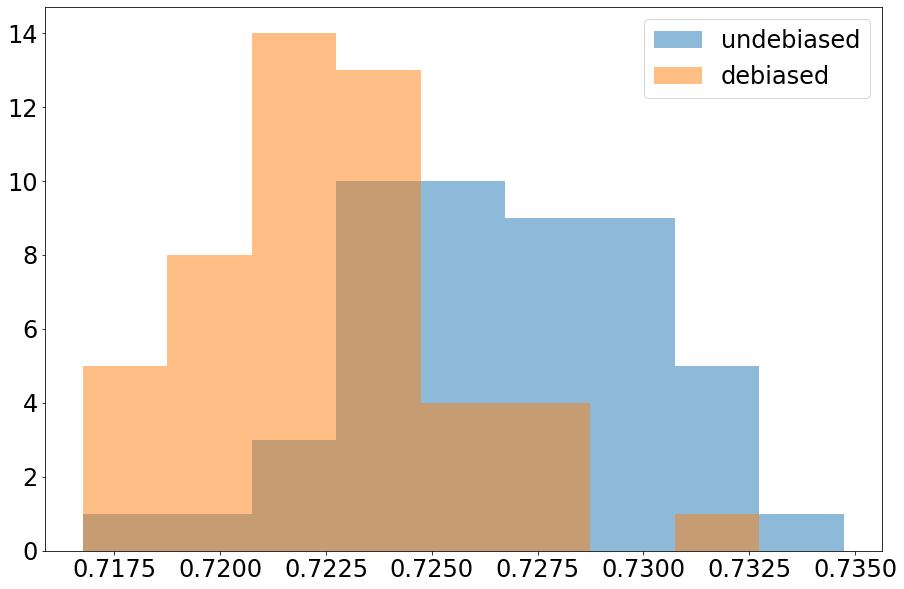

In [10]:
distribution(exp1, exp2, 10)

In [11]:
interval(exp1, 0.95)
interval(exp2, 0.95)

0.7246005228908553 < mean < 0.7290866728870377, 0.7268435978889465
0.7205928527347137 < mean < 0.7245669425495574, 0.7225798976421356


In [12]:
interval(exp1, 0.99)
interval(exp2, 0.99)

0.7238522526708283 < mean < 0.7298349431070646, 0.7268435978889465
0.7199299919158176 < mean < 0.7252298033684536, 0.7225798976421356
